## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn import impute
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import math

### (a) Download the APS Failure data

In [2]:
train_df = pd.read_csv('../data/aps_failure_training_set.csv',skiprows=20,delimiter=",")

In [3]:
train_y = train_df['class']

In [4]:
train_y

0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
59995    neg
59996    neg
59997    neg
59998    neg
59999    neg
Name: class, Length: 60000, dtype: object

In [5]:
train_df = train_df.drop(['class'],axis="columns")

In [6]:
train_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,na,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,na,0,na,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,na,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,0,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,60874,na,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002,na,664,186,0,0,0,0,0,2564,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,2286,na,2130706538,224,0,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,112,0,2130706432,18,0,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,80292,na,2130706432,494,0,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [7]:
test_df = pd.read_csv('../data/aps_failure_test_set.csv',skiprows=20,delimiter=",")

In [8]:
test_y = test_df['class']

In [9]:
test_y

0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
15995    neg
15996    neg
15997    neg
15998    neg
15999    neg
Name: class, Length: 16000, dtype: object

In [10]:
test_df = test_df.drop(['class'],axis="columns")

In [11]:
test_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0,20,12,0,0,0,0,0,2682,...,1098,138,412,654,78,88,0,0,0,0
1,82,0,68,40,0,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,66002,2,212,112,0,0,0,0,0,199486,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,59816,na,1010,936,0,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,1814,na,156,140,0,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852,na,2130706432,892,0,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
15996,18,0,52,46,8,26,0,0,0,0,...,266,44,46,14,2,0,0,0,0,0
15997,79636,na,1670,1518,0,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
15998,110,na,36,32,0,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

<font color="green">
Data imputation is the process of handling missing/incomplete values in a given dataset with estimated values. The basis for this estimation is driven by many methods. Some of them are:<br/>
1. Mean/Median/Mode imputation - <font color="red"><i>missing value estimation based on mean/median/mode</i></font><br/>
2. Regression imputation - <font color="red"><i>missing value estimation based on result of a regression model built for this purpose</i></font><br/>
3. K-Nearest Neighbors (KNN) imputation - <font color="red"><i>missing value estimation based on nearest neighbors</i></font><br/>
4. Multiple Imputation - <font color="red"><i>missing value estimation based on a combination of techniques</i></font><br/>
</font>

In [12]:
class Imputer():
    def __init__(self,train,test):
        self.train = train
        self.test = test
        self.col_names = self.fetch_column_names()
        
    def pre_process_data(self):
        self.train = self.train.replace(to_replace="na",value=np.nan)
        self.test = self.test.replace(to_replace="na",value=np.nan)
        for name in self.col_names:
            self.train[name] = self.train[name].astype(float)
            self.test[name] = self.test[name].astype(float)

    def impute_data(self):
        imputer = impute.SimpleImputer(missing_values=np.nan,strategy="mean")
        imputer = imputer.fit(self.train)
        return imputer
        
    def get_train_transformation(self,imputer):
        return pd.DataFrame(imputer.transform(self.train),columns=self.col_names)
        
    def get_test_transformation(self,imputer):
        return pd.DataFrame(imputer.transform(self.test),columns=self.col_names)
        
    def fetch_column_names(self):
        cnames = []
        for col in self.train.columns:
            cnames.append(col)
        return cnames
        
    def start_imputation(self):
        self.pre_process_data()
        impt = self.impute_data()
        self.train = self.get_train_transformation(impt)
        self.test = self.get_test_transformation(impt)
        
    def get_train_imputed_data(self):
        return self.train
    
    def get_test_imputed_data(self):
        return self.test

In [13]:
impute_model = Imputer(train_df,test_df)
impute_model.start_imputation()
train_x = impute_model.get_train_imputed_data()

In [14]:
train_x

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [15]:
test_x = impute_model.get_test_imputed_data()

In [16]:
test_x

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.713189,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.713189,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.713189,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.713189,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.713189,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


#### (ii) Calculate the coefficient of variation

In [17]:
class CoefficientVariation():
    def __init__(self,data):
        self.data = data
        self.fnames = self.fetch_column_names()
        self.mean = self.generate_means()
        self.std_dev = self.generate_std_deviation()
        self.coeff_variation = self.generate_coeff_variation()
        
    def fetch_column_names(self):
        cnames = []
        for col in self.data.columns:
            cnames.append(col)
        return cnames    
                
    def generate_means(self):
        means = {}
        for name in self.fnames:
            column = list(self.data[name])
            means[name] = self.get_sum(column)/len(column)
        return means
    
    def get_sum(self,column):
        csum = 0
        for num in column:
            csum += num
        return csum
    
    def generate_std_deviation(self):
        std_dev = {}
        for name in self.fnames:
            column = list(self.data[name])
            std_dev[name] = (self.get_sum(self.get_vsquare(column,self.mean.get(name)))/len(column))**0.5
        return std_dev
    
    def get_vsquare(self,col,mean):
        vsquare = []
        for num in col:
            vsquare.append((num-mean)**2)
        return vsquare
    
    def generate_coeff_variation(self):
        cv = []
        for name in self.fnames:
            cv.append(self.std_dev.get(name)/self.mean.get(name))
        return cv
            
    def get_coefficient_variation(self):
        return self.coeff_variation

In [18]:
def start_coeff_var_calc(data):
    cv_obj = CoefficientVariation(data)
    cv_data = cv_obj.get_coefficient_variation()
    return pd.DataFrame(cv_data,columns=['Coefficient Variation'],index=cv_obj.fetch_column_names())

In [19]:
train_cv = start_coeff_var_calc(train_x)

In [20]:
train_cv

,Coefficient Variation
aa_000,2.450917
ab_000,2.328381
ac_000,2.169748
ad_000,183.846088
ae_000,23.190743
...,...
ee_007,4.962441
ee_008,3.221983
ee_009,5.626932
ef_000,47.124560


In [21]:
test_cv = start_coeff_var_calc(test_x)

In [22]:
test_cv

,Coefficient Variation
aa_000,7.405023
ab_000,1.699142
ac_000,2.160451
ad_000,1.721794
ae_000,17.936797
...,...
ee_007,4.594280
ee_008,3.700004
ee_009,6.190136
ef_000,49.754839


In [23]:
full_data = pd.concat([train_x,test_x],axis=0)

In [24]:
full_data.index = list(range(0,76000))

In [25]:
full_data

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,81852.0,0.713189,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,18.0,0.000000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,79636.0,0.713189,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,110.0,0.713189,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [26]:
full_cv = start_coeff_var_calc(full_data)

In [27]:
full_cv

,Coefficient Variation
aa_000,4.328579
ab_000,2.207337
ac_000,2.167784
ad_000,193.954031
ae_000,22.282116
...,...
ee_007,4.885271
ee_008,3.335331
ee_009,5.754175
ef_000,47.780793


#### (iii) Plot a correlation matrix

[Text(0.5, 1.0, 'Correlation Matrix')]

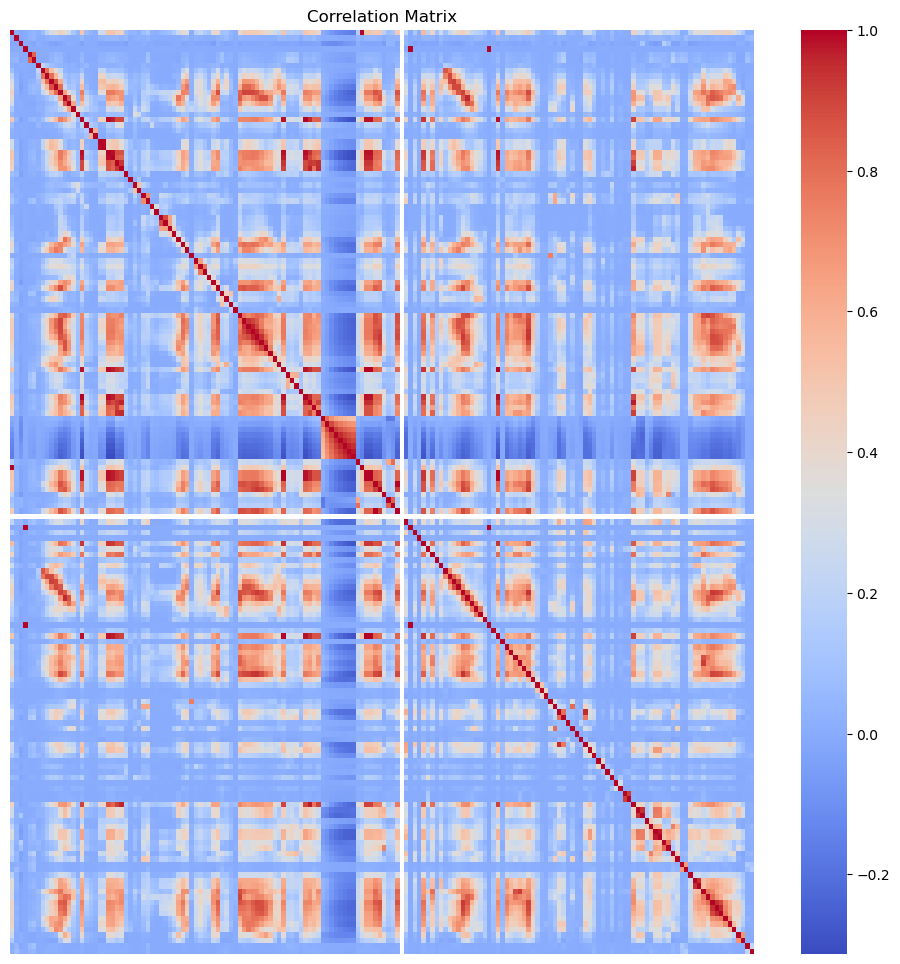

In [28]:
fit, ticks = plt.subplots(figsize=(12, 12))
seaborn.heatmap(full_data.corr(),cmap="coolwarm",xticklabels=False, yticklabels=False,ax=ticks).set(title="Correlation Matrix")

In [29]:
full_data.corr()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019562,-0.011690,-0.000472,0.025819,0.036032,0.011681,0.076380,0.195163,0.307446,...,0.414126,0.419913,0.409660,0.419782,0.425680,0.356969,0.259669,0.133764,0.006754,0.010299
ab_000,0.019562,1.000000,-0.010765,0.000076,0.025035,0.043458,0.000576,0.006554,0.023500,0.035739,...,0.024723,0.036606,0.028305,0.033824,0.023791,0.013550,0.001869,0.000198,0.046995,0.075732
ac_000,-0.011690,-0.010765,1.000000,-0.002125,-0.004769,-0.010612,0.015530,-0.002325,-0.009434,-0.022899,...,-0.009843,-0.006467,-0.007988,-0.008137,-0.014707,-0.018666,0.010423,0.017288,-0.006192,0.015826
ad_000,-0.000472,0.000076,-0.002125,1.000000,-0.000204,-0.000245,-0.000038,-0.000020,-0.000063,-0.000173,...,-0.000758,-0.000804,-0.000797,-0.000632,-0.000661,-0.000391,-0.000720,-0.000465,-0.000083,-0.000094
ae_000,0.025819,0.025035,-0.004769,-0.000204,1.000000,0.829986,-0.000440,-0.000604,0.001960,0.020700,...,0.012786,0.019473,0.012878,0.026469,0.066565,0.036649,-0.008379,-0.006947,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013550,-0.018666,-0.000391,0.036649,0.046529,0.007631,0.068003,0.181967,0.475570,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227099,0.063065,-0.000228,0.000908
ee_008,0.259669,0.001869,0.010423,-0.000720,-0.008379,-0.010821,0.000067,0.005352,0.009108,0.020683,...,0.442532,0.470574,0.448390,0.394021,0.365686,0.227099,1.000000,0.690147,-0.005137,-0.001966
ee_009,0.133764,0.000198,0.017288,-0.000465,-0.006947,-0.008531,-0.001103,-0.003540,-0.009090,-0.018164,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003156,-0.001065
ef_000,0.006754,0.046995,-0.006192,-0.000083,0.063587,0.093474,-0.000075,0.001152,0.005659,0.011098,...,0.003813,0.010263,0.003071,0.027007,0.005384,-0.000228,-0.005137,-0.003156,1.000000,0.222579


#### (iv) Make scatter plots and box plots

In [30]:
limit = math.floor(170**0.5)

In [31]:
fmap = {}
for name in full_cv.index:
    fmap[full_cv['Coefficient Variation'][name]] = name

In [32]:
fmap

{4.328579357658981: 'aa_000',
 2.207336846722729: 'ab_000',
 2.167784157381825: 'ac_000',
 193.9540311612: 'ad_000',
 22.28211642321542: 'ae_000',
 18.196878145413464: 'af_000',
 91.35068568819528: 'ag_000',
 42.17479945753106: 'ag_001',
 17.648270842664708: 'ag_002',
 8.758596487937998: 'ag_003',
 5.476635361461289: 'ag_004',
 2.9646350702296984: 'ag_005',
 2.3527075364256382: 'ag_006',
 2.8125739020799587: 'ag_007',
 6.275086220435788: 'ag_008',
 32.17661404480202: 'ag_009',
 2.315834591830549: 'ah_000',
 18.51785499433237: 'ai_000',
 43.153259522161605: 'aj_000',
 78.55947609922897: 'ak_000',
 9.11584087433884: 'al_000',
 9.070989441381284: 'am_0',
 2.254500874298183: 'an_000',
 2.276374773716262: 'ao_000',
 3.0863561258186714: 'ap_000',
 2.8538791857852988: 'aq_000',
 10.565158252077168: 'ar_000',
 114.46362820932701: 'as_000',
 23.192706061156166: 'at_000',
 86.29301307142197: 'au_000',
 5.736332005342614: 'av_000',
 3.860166286771778: 'ax_000',
 40.98766298011095: 'ay_000',
 49.3

In [33]:
inp_cv = list(full_cv['Coefficient Variation'])
inp_cv.sort()
inp_cv = inp_cv[-1:-limit-1:-1]

In [34]:
inp_cv

[194.43704350739245,
 194.08789141767502,
 193.9540311612,
 193.04376479958296,
 120.08411045140494,
 116.13740819984295,
 114.46362820932701,
 111.94565976545415,
 91.35068568819528,
 86.29301307142197,
 78.55947609922897,
 77.89401217527244,
 77.45725130705509]

In [35]:
fnm = []
for value in inp_cv:
    fnm.append(fmap.get(value))

In [36]:
fnm

['cf_000',
 'co_000',
 'ad_000',
 'cs_009',
 'dj_000',
 'df_000',
 'as_000',
 'dh_000',
 'ag_000',
 'au_000',
 'ak_000',
 'az_009',
 'ay_009']

In [37]:
plot_data = full_data[fnm]

In [38]:
plot_data

,cf_000,co_000,ad_000,cs_009,dj_000,df_000,as_000,dh_000,ag_000,au_000,ak_000,az_009,ay_009
0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,2.000000,42.000000,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75996,2.000000,0.000000,46.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75997,2.000000,378.000000,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75998,0.000000,0.000000,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


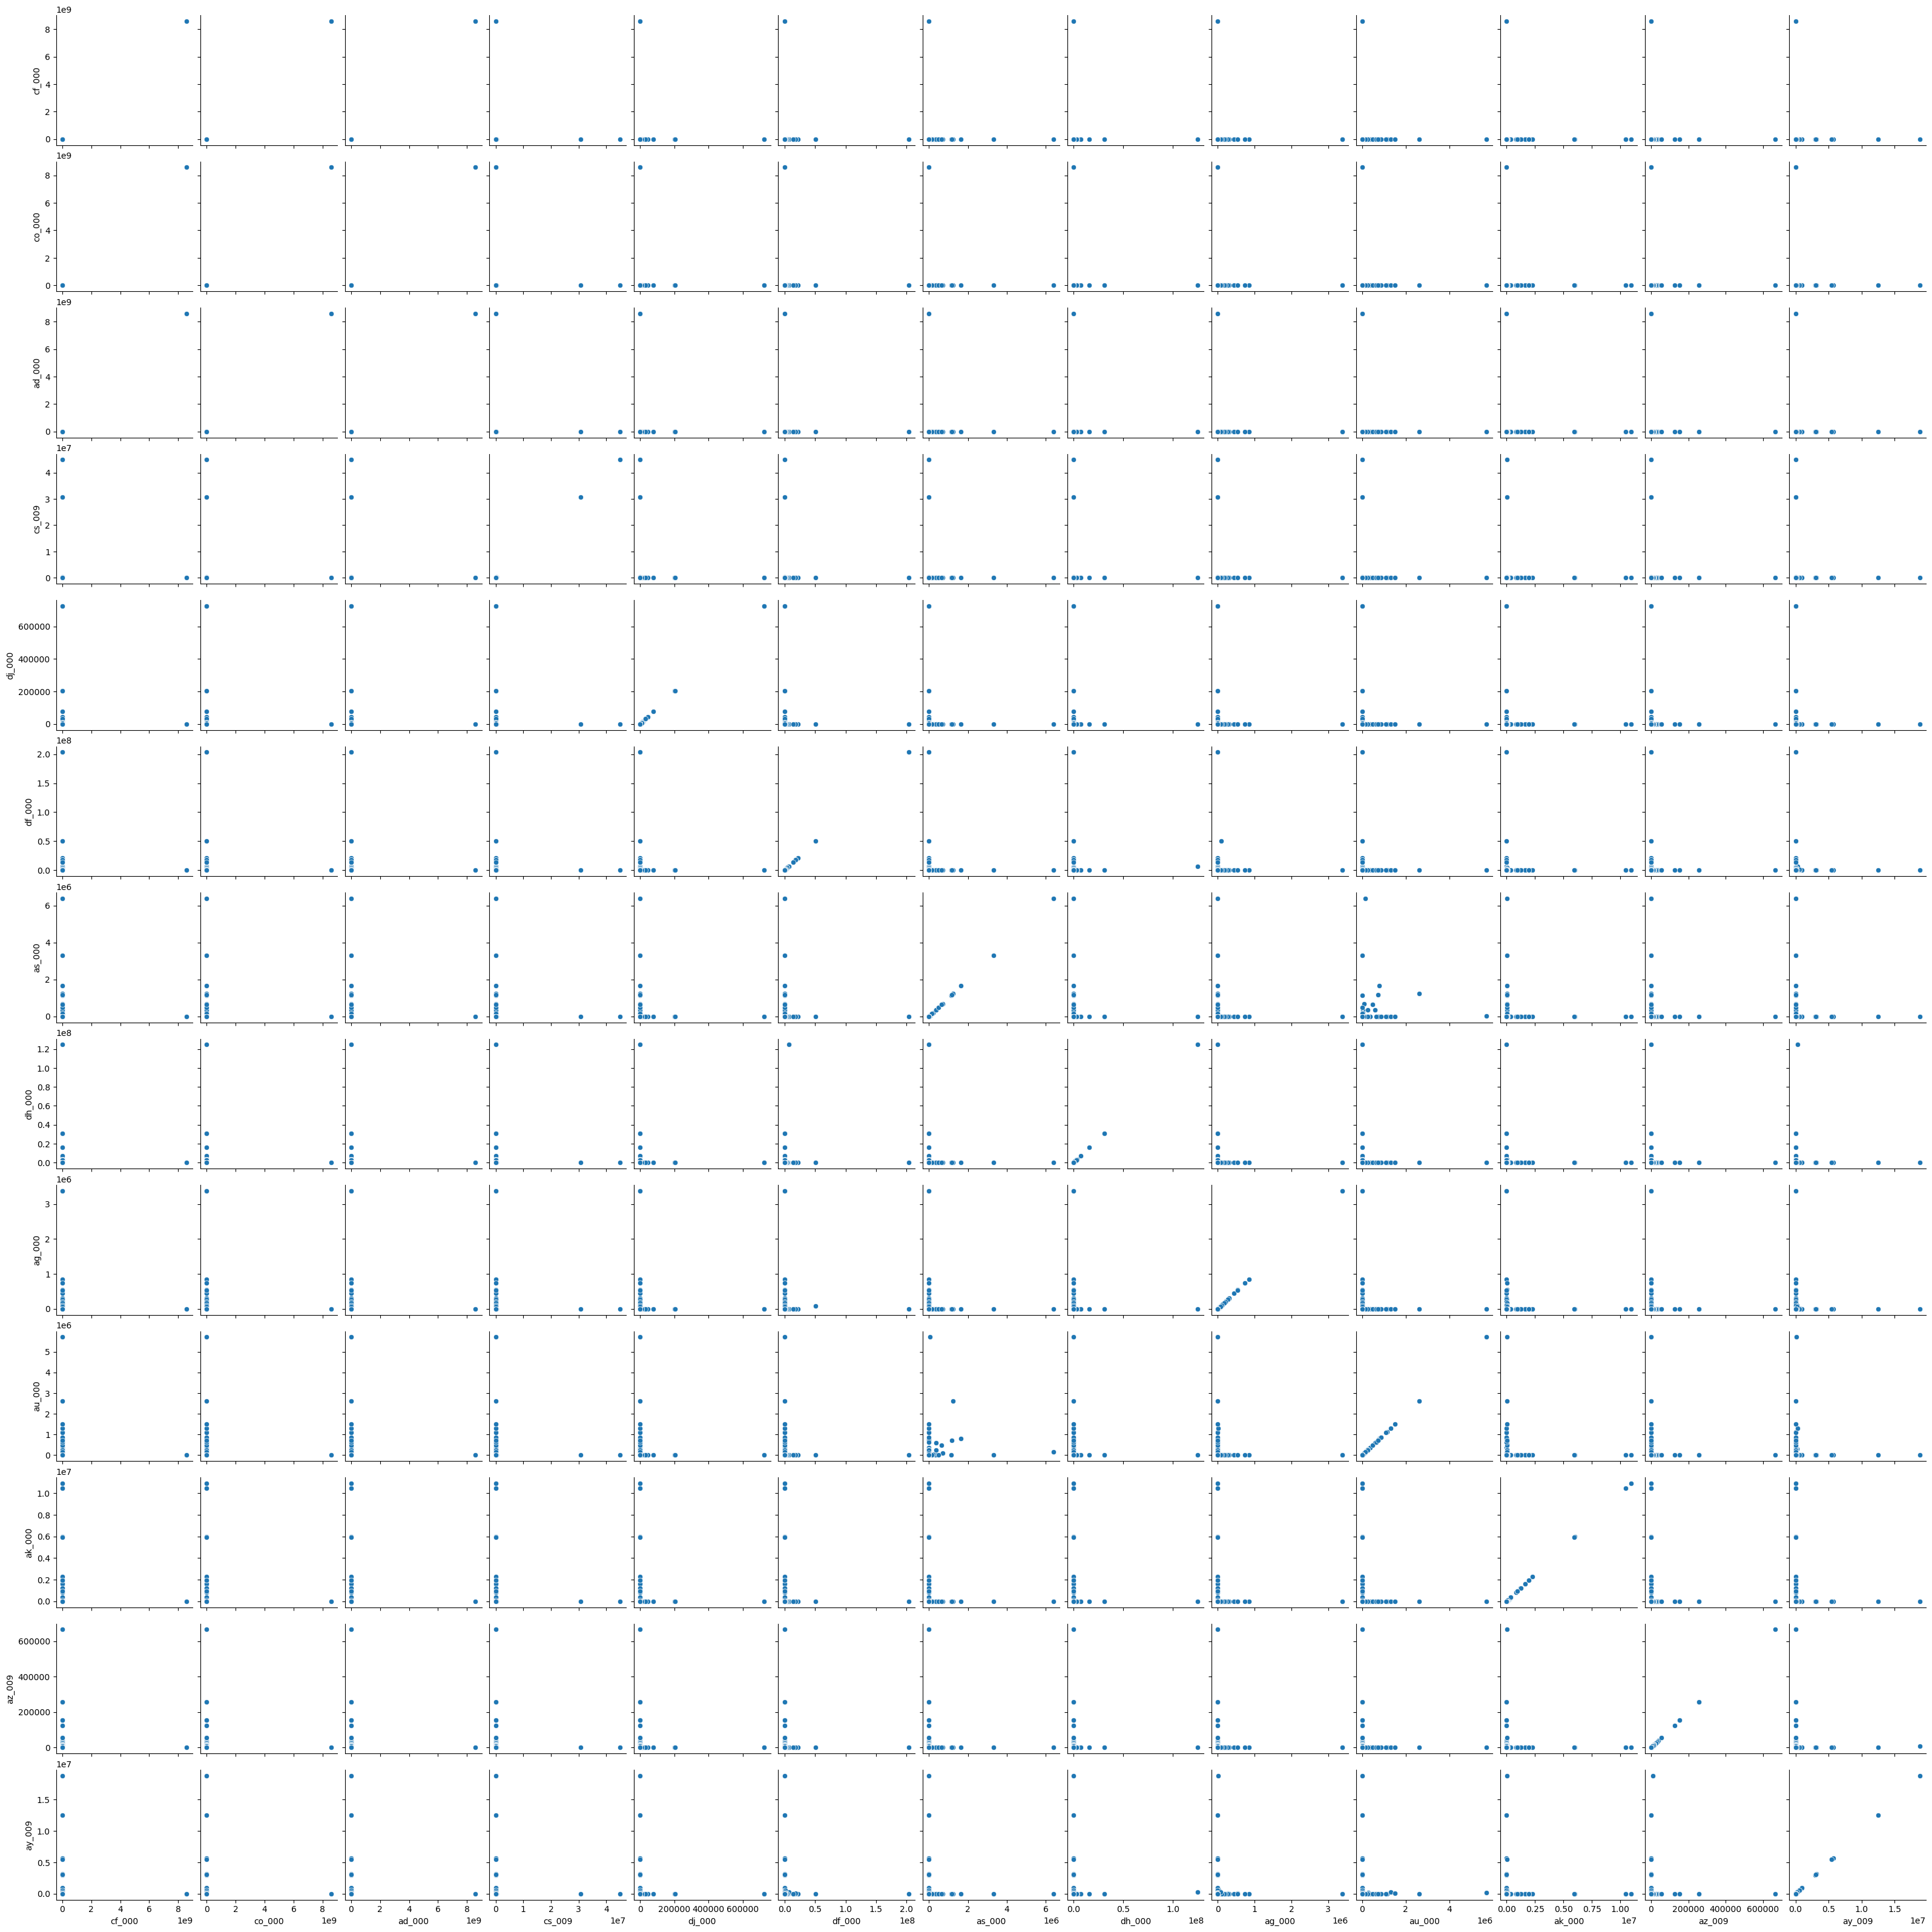

In [39]:
seaborn.pairplot(plot_data,diag_kind=None)

In [40]:
full_y = pd.concat([train_y,test_y],axis=0)
full_y.index = list(range(0,76000))

In [41]:
full_y

0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
75995    neg
75996    neg
75997    neg
75998    neg
75999    neg
Name: class, Length: 76000, dtype: object

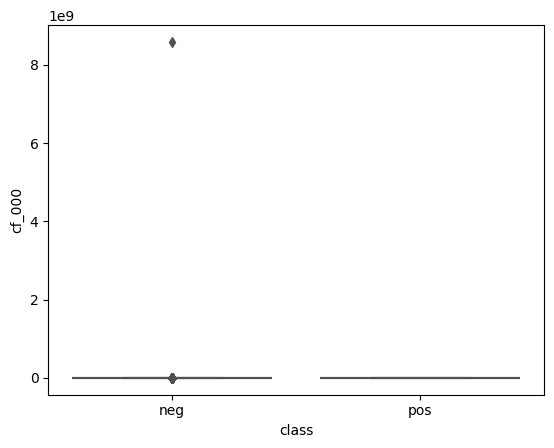

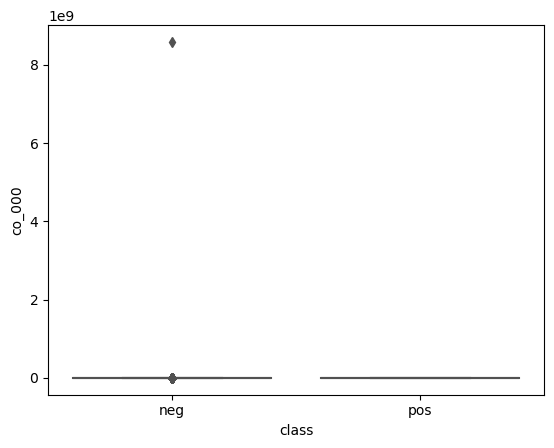

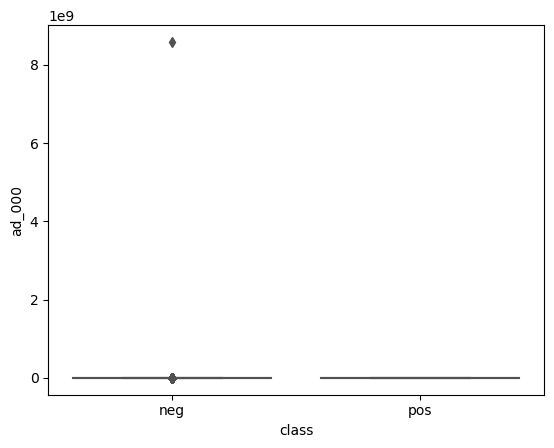

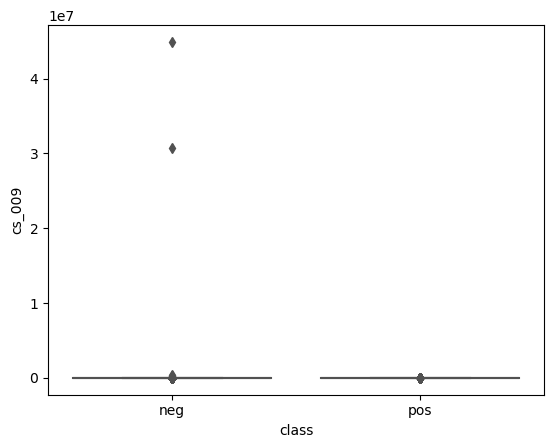

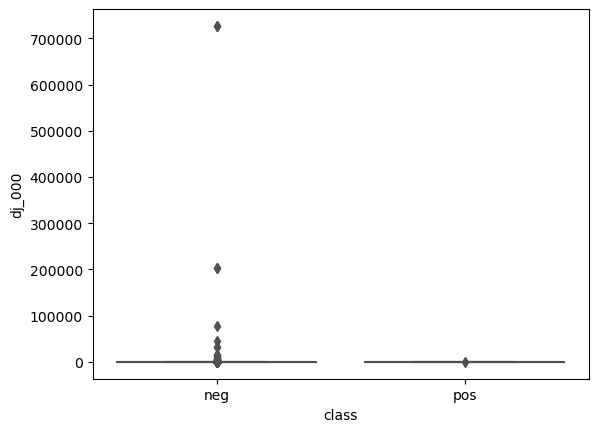

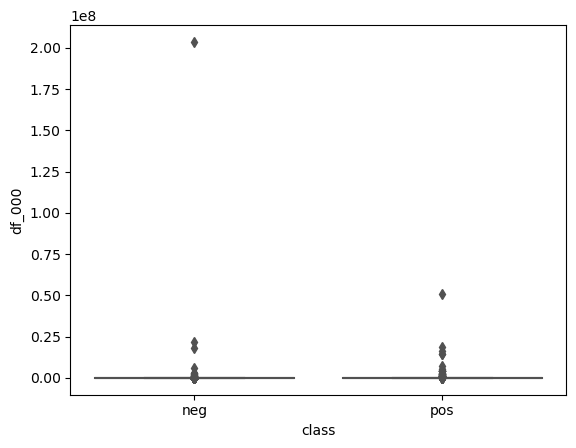

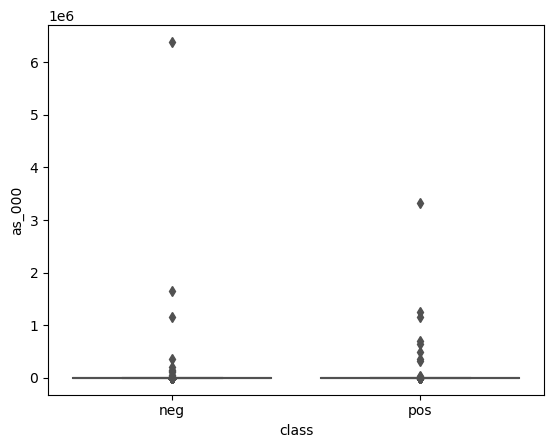

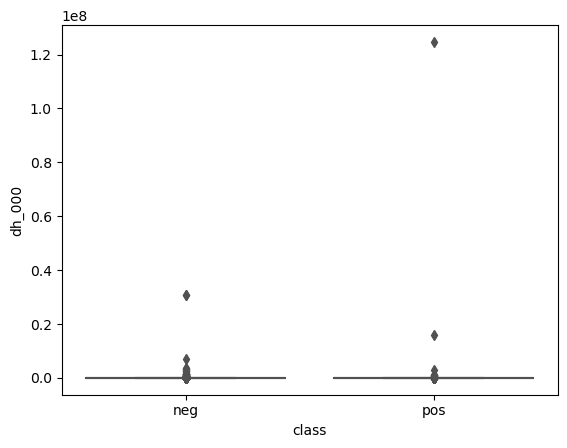

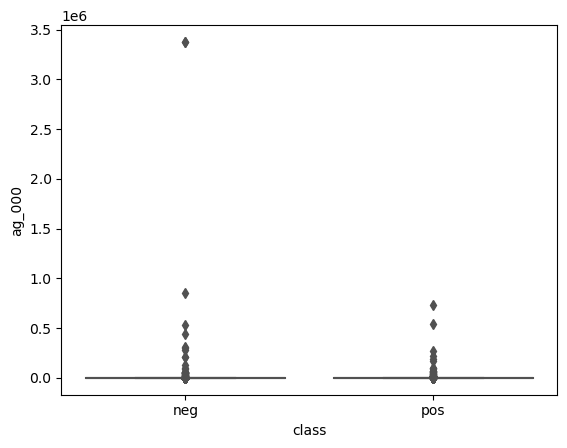

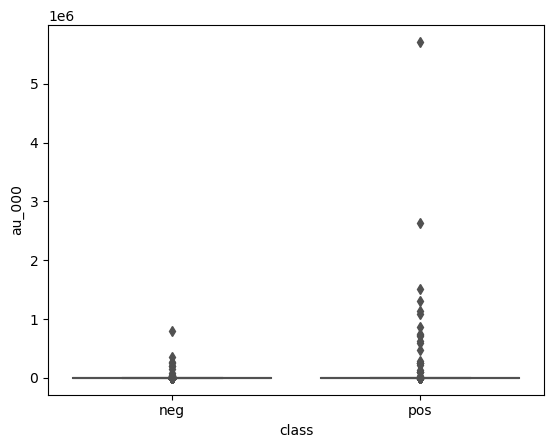

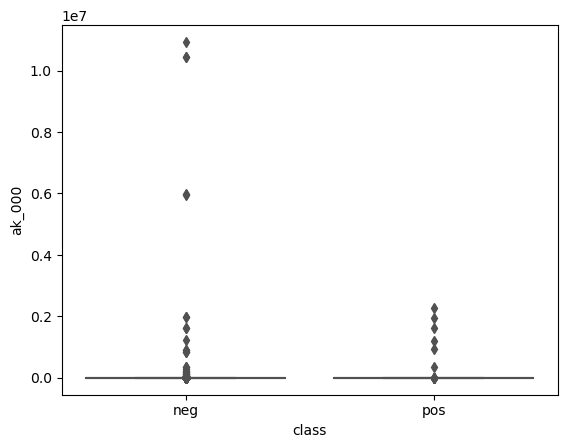

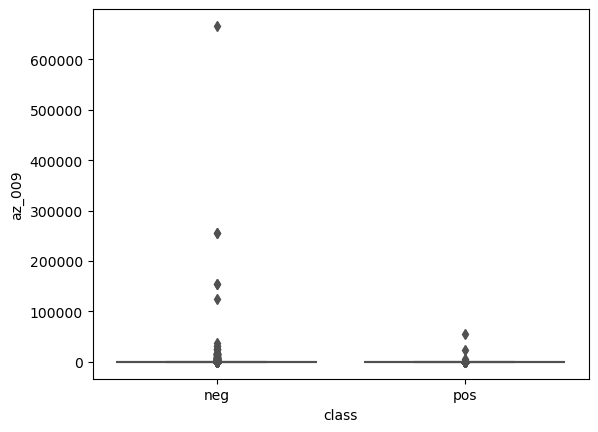

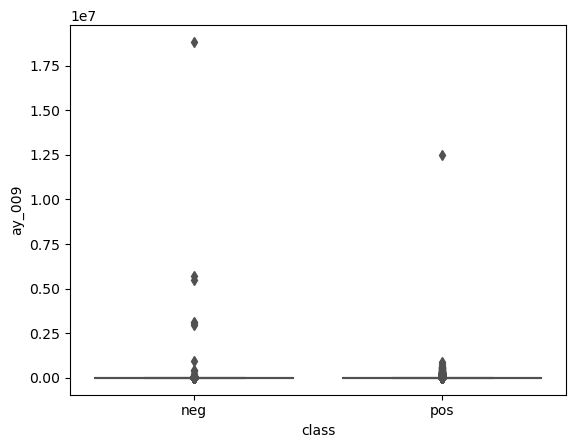

In [42]:
for feature in fnm:
    seaborn.boxplot(y=plot_data[feature],x=full_y,palette="GnBu",)
    plt.show()

<font color="green">Just by scatter plots, we cannot identify the significance of features in a dataset even if we have all the features as scatter plots do not account for potential patterns and outliers. Scatter plots are useful for visualizing the relationship between two variables, but they do not provide information about the statistical significance of that relationship or the relative importance of the variables.</font>

#### (v) Is this data set imbalanced?

In [43]:
y = list(train_y)

In [44]:
y.extend(list(test_y))

In [45]:
print(f'Number of positive data = {y.count("pos")}')
print(f'Number of negative data = {y.count("neg")}')

Number of positive data = 1375
Number of negative data = 74625


<font color="blue">Based on the significant difference in the count positive and negative data, we can conclude that this dataset is highly imbalance.</font>

### (c) Train a random forest

In [46]:
def y_mapping(data):
    if data == "neg":
        return 0
    else:
        return 1

In [47]:
tr_dat = list(map(y_mapping,list(train_y)))
tr_y = pd.DataFrame(tr_dat,columns=['class'])

In [48]:
tr_y

,class
0,0
1,0
2,0
3,0
4,0
...,...
59995,0
59996,0
59997,0
59998,0


In [49]:
tst_dat = list(map(y_mapping,list(test_y)))
tst_y = pd.DataFrame(tst_dat,columns=['class'])

In [50]:
tst_y

,class
0,0
1,0
2,0
3,0
4,0
...,...
15995,0
15996,0
15997,0
15998,0


In [51]:
rforest = RandomForestClassifier(oob_score=True)
rforest = rforest.fit(train_x,tr_y)
tr_pred = rforest.predict(train_x)
tr_accuracy = accuracy_score(tr_y,tr_pred)
print(f'Model Accuracy Score = {tr_accuracy}')
print(f'Model Train Error = {1-tr_accuracy}')

C:\Users\vinut\AppData\Local\Temp\ipykernel_47792\2880907771.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforest = rforest.fit(train_x,tr_y)


Model Accuracy Score = 1.0
Model Train Error = 0.0


In [52]:
tr_pred_prob = rforest.predict_proba(train_x)
print('prediction probability\n')
print(tr_pred_prob)
tr_conf_mat = confusion_matrix(tr_y,tr_pred)
print('\nconfusion matrix:')
print(tr_conf_mat)

prediction probability

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

confusion matrix:
[[59000     0]
 [    0  1000]]


In [53]:
tr_fp_rate, tr_tp_rate, tr_limit = metrics.roc_curve(tr_y, tr_pred_prob[:,1], pos_label=1)
train_auc = metrics.auc(tr_fp_rate, tr_tp_rate)
print(f'Area under the curve = {train_auc}')

Area under the curve = 1.0


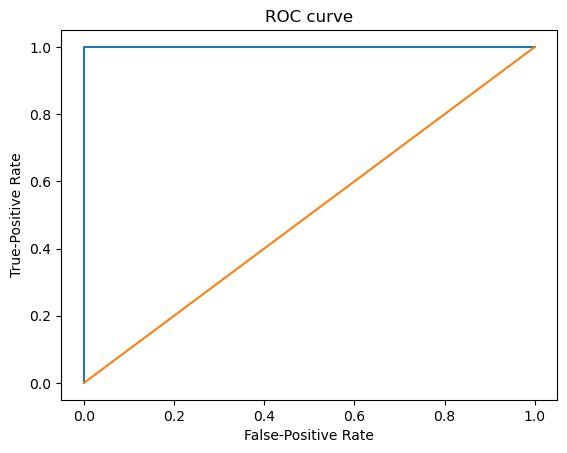

In [54]:
plt.plot(tr_fp_rate, tr_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [55]:
tst_pred = rforest.predict(test_x)
tst_accuracy = accuracy_score(tst_y,tst_pred)
print(f'Model Accuracy Score = {tst_accuracy}')
print(f'Model Test Error = {1-tst_accuracy}')

Model Accuracy Score = 0.9920625
Model Test Error = 0.007937500000000042


In [56]:
tst_pred_prob = rforest.predict_proba(test_x)
print('prediction probability')
print(tst_pred_prob)
tst_conf_mat = confusion_matrix(tst_y,tst_pred)
print('\nconfusion matrix:')
print(tst_conf_mat)

prediction probability
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

confusion matrix:
[[15606    19]
 [  108   267]]


In [57]:
tst_fp_rate, tst_tp_rate, tst_limit = metrics.roc_curve(tst_y, tst_pred_prob[:,1], pos_label=1)
test_auc = metrics.auc(tst_fp_rate, tst_tp_rate)
print(f'Area under the curve = {test_auc}')

Area under the curve = 0.9942754133333335


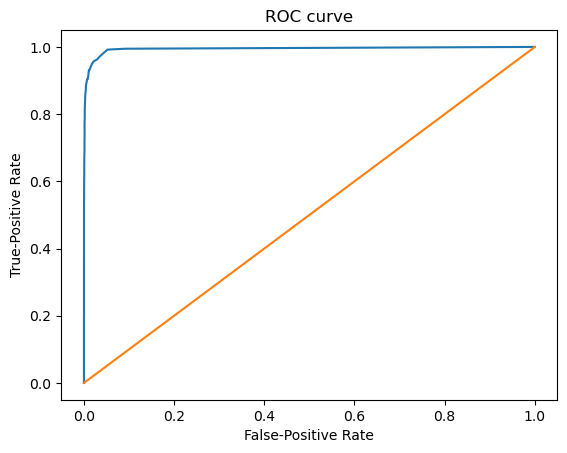

In [58]:
plt.plot(tst_fp_rate, tst_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [59]:
print(f"Model's Out Of Bag Error = {1-rforest.oob_score_}")

Model's Out Of Bag Error = 0.006116666666666659


<font color="blue">
    As seen above, the test error is <font color="green">0.007937500000000042</font> and the out of bag error is <font color="green">0.006116666666666659</font>.<br/><font color="orange">The out of bag error is calculated by leaving out one or more data points during the training process of each individual model in the ensemble, and then using the left out data points to evaluate the performance of the model. The average of these evaluations over all the models in the ensemble gives an estimate of the out of bag error. The test error on the other hand is directly based on the number of miscalculations between the predicted Y and the true Y. In our case, out of bag error is only slightly lower than the test error which means that our model can generalize pretty well.</font>
</font>

### (d) Research class imbalance in random forest

<font color="green">
Class imbalance in random forests can be handled in many ways. Some of them are:<br/>
1. <strong>Resampling</strong>: This can be done by oversampling the minority class or undersampling the majority class. Oversampling the minority class means adding duplicates of the minority class samples and undersampling the majority class means removing samples from the majority class. Both of these techniques can lead to overfitting and loss of information.<br/>
2. <strong>Class Weighting</strong>: This is done by assigning weights to class during training such that the minority class gets higher weights and majority class gets lower weights. This way the minority class is preffered by the algorithm during training.<br/>
3. <strong>Ensemble Methods</strong>: Ensemble Methods such as Balanced Random Forest which involves undersampling with bootstrapping to generate balanced samples for training.<br/>
</font>

#### Random forest with class weighting

In [60]:
rbforest = RandomForestClassifier(oob_score=True,class_weight="balanced")
rbforest = rbforest.fit(train_x,tr_y)
tr_bal_pred = rbforest.predict(train_x)
tr_bal_accuracy = accuracy_score(tr_y,tr_bal_pred)
print(f'Model Accuracy Score = {tr_bal_accuracy}')
print(f'Model Train Error = {1-tr_bal_accuracy}')

C:\Users\vinut\AppData\Local\Temp\ipykernel_47792\3103668823.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rbforest = rbforest.fit(train_x,tr_y)


Model Accuracy Score = 1.0
Model Train Error = 0.0


In [61]:
tr_bal_pred_prob = rbforest.predict_proba(train_x)
print('prediction probability\n')
print(tr_bal_pred_prob)
tr_bal_conf_mat = confusion_matrix(tr_y,tr_bal_pred)
print('\nconfusion matrix:')
print(tr_bal_conf_mat)

prediction probability

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

confusion matrix:
[[59000     0]
 [    0  1000]]


In [62]:
tr_bal_fp_rate, tr_bal_tp_rate, tr_bal_limit = metrics.roc_curve(tr_y, tr_bal_pred_prob[:,1], pos_label=1)
train_bal_auc = metrics.auc(tr_bal_fp_rate, tr_bal_tp_rate)
print(f'Area under the curve = {train_bal_auc}')

Area under the curve = 1.0


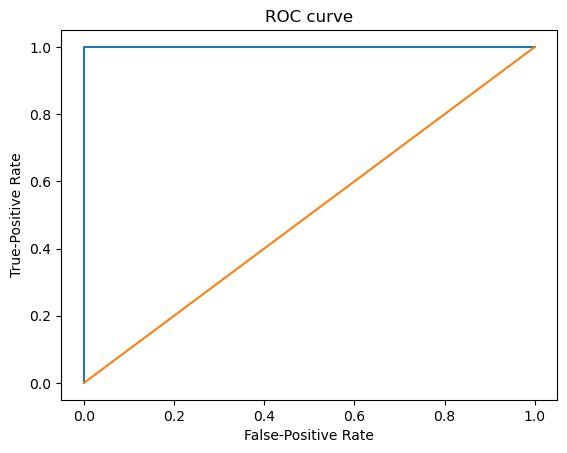

In [63]:
plt.plot(tr_bal_fp_rate, tr_bal_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [64]:
tst_bal_pred = rbforest.predict(test_x)
tst_bal_accuracy = accuracy_score(tst_y,tst_bal_pred)
print(f'Model Accuracy Score = {tst_bal_accuracy}')
print(f'Model Test Error = {1-tst_bal_accuracy}')

Model Accuracy Score = 0.989
Model Test Error = 0.01100000000000001


In [65]:
tst_bal_pred_prob = rbforest.predict_proba(test_x)
print('prediction probability\n')
print(tst_bal_pred_prob)
tst_bal_conf_mat = confusion_matrix(tst_y,tst_bal_pred)
print('\nconfusion matrix:')
print(tst_bal_conf_mat)

prediction probability

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

confusion matrix:
[[15611    14]
 [  162   213]]


In [66]:
tst_bal_fp_rate, tst_bal_tp_rate, tst_bal_limit = metrics.roc_curve(tst_y, tst_bal_pred_prob[:,1], pos_label=1)
test_bal_auc = metrics.auc(tst_bal_fp_rate, tst_bal_tp_rate)
print(f'Area under the curve = {test_bal_auc}')

Area under the curve = 0.9914430293333334


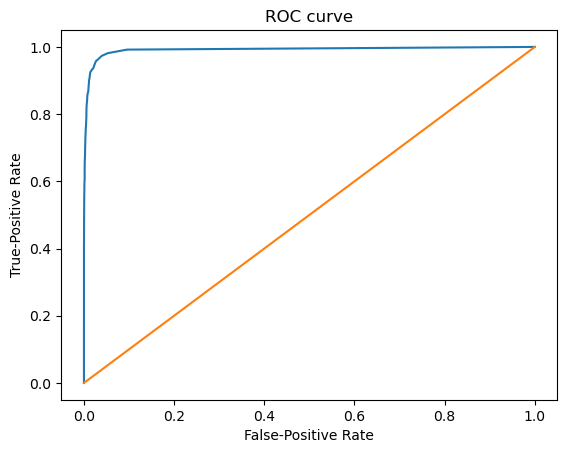

In [67]:
plt.plot(tst_bal_fp_rate, tst_bal_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [68]:
print(f"Model's Out Of Bag Error = {1-rbforest.oob_score_}")

Model's Out Of Bag Error = 0.007750000000000035


In [69]:
cons_data = [[(1-tr_accuracy),(1-tst_accuracy),(1-rforest.oob_score_)],[(1-tr_bal_accuracy),(1-tst_bal_accuracy),(1-rbforest.oob_score_)]]

In [70]:
cons_df = pd.DataFrame(cons_data,columns=['Train Error','Test Error','Out Of Bag Error'],index=['Random forest w/o balancing',
                                                                                               'Random forest w/ balancing'])

In [71]:
cons_df

,Train Error,Test Error,Out Of Bag Error
Random forest w/o balancing,0.0,0.007938,0.006117
Random forest w/ balancing,0.0,0.011000,0.007750


<font color="purple">In our case, based on the input dataset, model metrics, and balancing techniques, we can see that the Random Forest model built without balancing has slightly lower test error and out of bag error than Random forest model with dataset balanced using class weighting.</font>

### (e) XGBoost and Model Trees

In [72]:
alpha = [10, 5, 1, 0.1, 0.01, 0.001]
xgb_model = XGBClassifier(objective='binary:logistic')

In [73]:
param = {'reg_alpha': alpha}
xgb_cv = GridSearchCV(xgb_model,param, cv=5)
xgb_cv = xgb_cv.fit(train_x, tr_y)

In [74]:
best_alpha = xgb_cv.best_params_['reg_alpha']
print(f'Best regularization term: {best_alpha}')

Best regularization term: 0.001


In [75]:
cv_error = 1 - xgb_cv.best_score_
print(f'CV error = {cv_error}')

CV error = 0.005400000000000071


In [76]:
xmodel = XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha).fit(train_x, tr_y)
y_xgb_tr_pred = xmodel.predict(train_x)
xgb_accuracy_score = accuracy_score(tr_y,y_xgb_tr_pred)
xgb_tr_mse = metrics.mean_squared_error(tr_y,y_xgb_tr_pred)
print(f'Model training accuracy score: {xgb_accuracy_score}')
print(f'Model training error: {1-xgb_accuracy_score}')
print(f'Model training MSE: {xgb_tr_mse}')

Model training accuracy score: 0.9999833333333333
Model training error: 1.666666666666483e-05
Model training MSE: 1.6666666666666667e-05


In [77]:
tr_xgb_pred_prob = xmodel.predict_proba(train_x)
print('prediction probability\n')
print(tr_xgb_pred_prob)
tr_xgb_conf_mat = confusion_matrix(tr_y,y_xgb_tr_pred)
print('\nconfusion matrix:')
print(tr_xgb_conf_mat)

prediction probability

[[9.9987483e-01 1.2516302e-04]
 [9.9998420e-01 1.5814729e-05]
 [9.9999797e-01 2.0521675e-06]
 ...
 [9.9999696e-01 3.0279707e-06]
 [9.9970460e-01 2.9538997e-04]
 [9.9999714e-01 2.8774971e-06]]

confusion matrix:
[[59000     0]
 [    1   999]]


In [78]:
tr_xgb_fp_rate, tr_xgb_tp_rate, tr_xgb_limit = metrics.roc_curve(tr_y, tr_xgb_pred_prob[:,1], pos_label=1)
tr_xgb_auc = metrics.auc(tr_xgb_fp_rate, tr_xgb_tp_rate)
print(f'Area under the curve = {tr_xgb_auc}')

Area under the curve = 0.9999980508474576


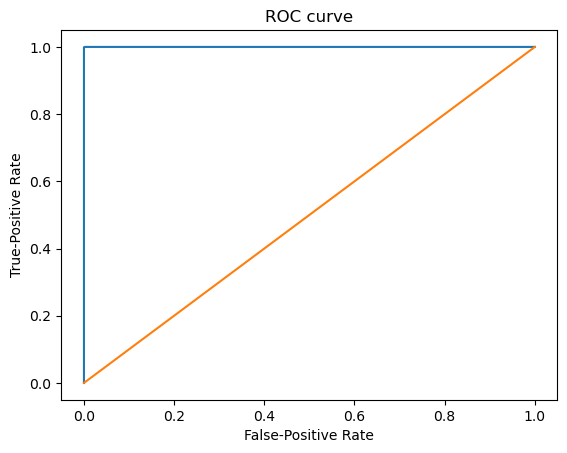

In [79]:
plt.plot(tr_xgb_fp_rate, tr_xgb_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [80]:
y_xgb_tst_pred = xmodel.predict(test_x)
x_accuracy_score = accuracy_score(tst_y,y_xgb_tst_pred)
xgb_tst_mse = metrics.mean_squared_error(tst_y,y_xgb_tst_pred)
print(f'Model test accuracy score: {x_accuracy_score}')
print(f'Model test error: {1-x_accuracy_score}')
print(f'Model test MSE: {xgb_tst_mse}')

Model test accuracy score: 0.99375
Model test error: 0.006249999999999978
Model test MSE: 0.00625


In [81]:
tst_xgb_pred_prob = xmodel.predict_proba(test_x)
print('prediction probability\n')
print(tst_xgb_pred_prob)
tst_xgb_conf_mat = confusion_matrix(tst_y,y_xgb_tst_pred)
print('\nconfusion matrix:')
print(tst_xgb_conf_mat)

prediction probability

[[9.99884248e-01 1.15740295e-04]
 [9.99998510e-01 1.47717185e-06]
 [9.99988735e-01 1.12502903e-05]
 ...
 [9.99979436e-01 2.05870692e-05]
 [9.99289393e-01 7.10601627e-04]
 [9.99982297e-01 1.76951780e-05]]

confusion matrix:
[[15608    17]
 [   83   292]]


In [82]:
tst_xgb_fp_rate, tst_xgb_tp_rate, tst_xgb_limit = metrics.roc_curve(tst_y, tst_xgb_pred_prob[:,1], pos_label=1)
tst_xgb_auc = metrics.auc(tst_xgb_fp_rate, tst_xgb_tp_rate)
print(f'Area under the curve = {tst_xgb_auc}')

Area under the curve = 0.994866688


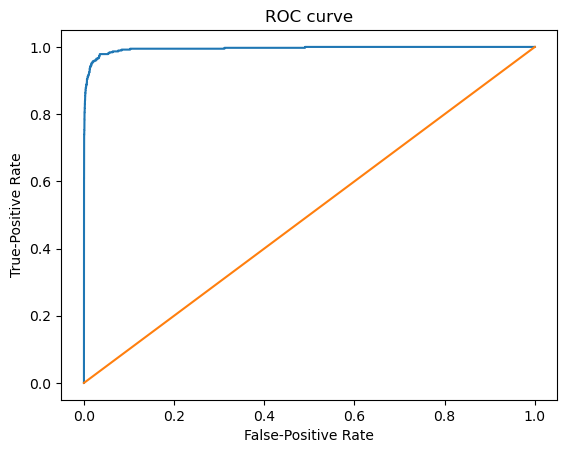

In [83]:
plt.plot(tst_xgb_fp_rate, tst_xgb_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [84]:
cv_comp = pd.DataFrame([[cv_error,1-x_accuracy_score]],columns=['CV Error','Test Error'])

In [85]:
cv_comp

,CV Error,Test Error
0,0.0054,0.00625


<font color="brown">CV error is dependent on the particular dataset we have, and actual test error is dependent on best CV model selected. In our model, CV Error or cross validation error of the trained model is lesser than test error</font>

### (f) Use SMOTE to pre-process your data

In [86]:
smote = SMOTE()
smote_tr_x, smote_tr_y = smote.fit_resample(train_x, tr_y)

In [87]:
comp_data = [[list(tr_y['class']).count(0),list(tr_y['class']).count(1)],[list(smote_tr_y['class']).count(0),list(smote_tr_y['class']).count(1)]]
comp_df = pd.DataFrame(comp_data,columns=["Number of neg's in the dataset","Number of neg's in the dataset"],
                      index=['Before balancing','After Balancing with SMOTE'])

In [88]:
comp_df

,Number of neg's in the dataset,Number of neg's in the dataset
Before balancing,59000,1000
After Balancing with SMOTE,59000,59000


In [89]:
alpha = [10, 5, 1, 0.1, 0.01, 0.001, 0]
sm_xgb_model = XGBClassifier(objective='binary:logistic')

In [90]:
param = {'reg_alpha': alpha}
sm_xgb_cv = GridSearchCV(sm_xgb_model,param, cv=5)
sm_xgb_cv = sm_xgb_cv.fit(smote_tr_x, smote_tr_y)

In [91]:
sm_best_alpha = sm_xgb_cv.best_params_['reg_alpha']
print(f'Best regularization term: {sm_best_alpha}')

Best regularization term: 0.001


In [92]:
sm_cv_error = 1 - sm_xgb_cv.best_score_
print(f'CV error = {sm_cv_error}')

CV error = 0.0026186440677966605


In [93]:
sm_xmodel = XGBClassifier(objective='binary:logistic', reg_alpha=sm_best_alpha).fit(smote_tr_x, smote_tr_y)
y_sm_tr_pred = sm_xmodel.predict(train_x)
sm_accuracy_score = accuracy_score(tr_y,y_sm_tr_pred)
sm_tr_mse = metrics.mean_squared_error(tr_y,y_sm_tr_pred)
print(f'Model training accuracy score: {sm_accuracy_score}')
print(f'Model training error: {1-sm_accuracy_score}')
print(f'Model training MSE: {sm_tr_mse}')

Model training accuracy score: 0.9999833333333333
Model training error: 1.666666666666483e-05
Model training MSE: 1.6666666666666667e-05


In [94]:
tr_sm_pred_prob = sm_xmodel.predict_proba(train_x)
print('prediction probability\n')
print(tr_sm_pred_prob)
tr_sm_conf_mat = confusion_matrix(tr_y,y_sm_tr_pred)
print('\nconfusion matrix:')
print(tr_sm_conf_mat)

prediction probability

[[9.9957013e-01 4.2986934e-04]
 [9.9999440e-01 5.5781106e-06]
 [9.9999851e-01 1.5014845e-06]
 ...
 [9.9998266e-01 1.7339546e-05]
 [9.9982190e-01 1.7808698e-04]
 [9.9999654e-01 3.4624779e-06]]

confusion matrix:
[[59000     0]
 [    1   999]]


In [95]:
tr_sm_fp_rate, tr_sm_tp_rate, tr_sm_limit = metrics.roc_curve(tr_y, tr_sm_pred_prob[:,1], pos_label=1)
tr_sm_auc = metrics.auc(tr_sm_fp_rate, tr_sm_tp_rate)
print(f'Area under the curve = {tr_sm_auc}')

Area under the curve = 0.9999984576271187


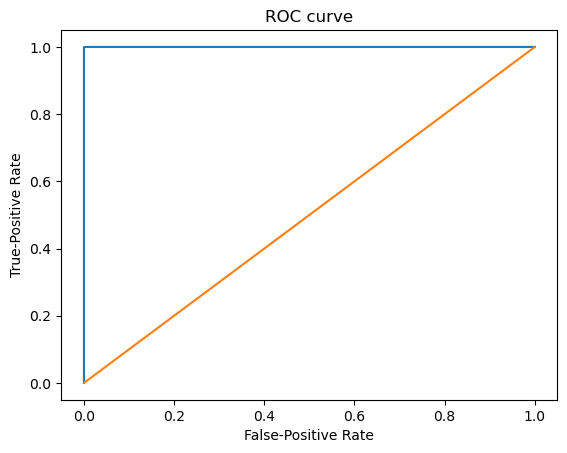

In [96]:
plt.plot(tr_sm_fp_rate, tr_sm_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [97]:
y_sm_tst_pred = sm_xmodel.predict(test_x)
sm_tst_accuracy_score = accuracy_score(tst_y,y_sm_tst_pred)
sm_tst_mse = metrics.mean_squared_error(tst_y,y_sm_tst_pred)
print(f'Model test accuracy score: {sm_tst_accuracy_score}')
print(f'Model test error: {1-sm_tst_accuracy_score}')
print(f'Model test MSE: {sm_tst_mse}')

Model test accuracy score: 0.9926875
Model test error: 0.007312500000000055
Model test MSE: 0.0073125


In [98]:
tst_sm_pred_prob = sm_xmodel.predict_proba(test_x)
print('prediction probability\n')
print(tst_sm_pred_prob)
tst_sm_conf_mat = confusion_matrix(np.array(tst_y).flatten(),y_sm_tst_pred)
print('\nconfusion matrix:')
print(tst_sm_conf_mat)

prediction probability

[[9.9999499e-01 5.0239973e-06]
 [9.9999446e-01 5.5280234e-06]
 [9.9991375e-01 8.6237822e-05]
 ...
 [9.9999195e-01 8.0384134e-06]
 [9.9986029e-01 1.3968628e-04]
 [9.9999785e-01 2.1287090e-06]]

confusion matrix:
[[15573    52]
 [   65   310]]


In [99]:
tst_sm_fp_rate, tst_sm_tp_rate, tst_sm_limit = metrics.roc_curve(tst_y, tst_sm_pred_prob[:,1], pos_label=1)
tst_sm_auc = metrics.auc(tst_sm_fp_rate, tst_sm_tp_rate)
print(f'Area under the curve = {tst_sm_auc}')

Area under the curve = 0.9943939413333333


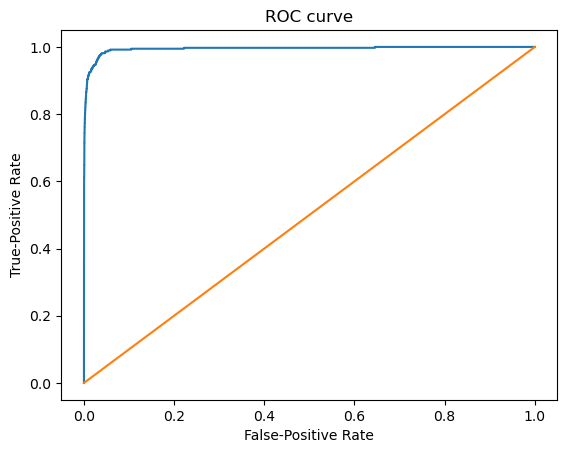

In [100]:
plt.plot(tst_sm_fp_rate, tst_sm_tp_rate)
plt.plot([0,1],[0,1])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC curve')
plt.show()

In [101]:
sm_cv_comp = pd.DataFrame([[sm_cv_error,1-sm_tst_accuracy_score]],columns=['CV Error','Test Error'])

In [102]:
sm_cv_comp

,CV Error,Test Error
0,0.002619,0.007313


CV error is dependent on the particular dataset we have, and actual test error is dependent on best CV model selected. In our model, CV Error or cross validation error of the trained model is lesser than test error

#### Result Comparison

In [103]:
res = [[tr_accuracy,(1-tr_accuracy),"-",train_auc],
       [tst_accuracy,(1-tst_accuracy),"-",test_auc],
       [tr_bal_accuracy,(1-tr_bal_accuracy),"-",train_bal_auc],
       [tst_bal_accuracy,(1-tst_bal_accuracy),"-",test_bal_auc],
       [xgb_accuracy_score,(1-xgb_accuracy_score),xgb_tr_mse,tr_xgb_auc],
       [x_accuracy_score,(1-x_accuracy_score),xgb_tst_mse,tst_xgb_auc],
       [sm_accuracy_score,(1-sm_accuracy_score),sm_tr_mse,tr_sm_auc],
       [sm_tst_accuracy_score,(1-sm_tst_accuracy_score),sm_tst_mse,tst_sm_auc]]
res_df = pd.DataFrame(res,columns=['Model Accuracy','Model Error','Model MSE','Model AUC'],
                     index=['Random forest w/o balancing - Training Data',
                           'Random forest w/o balancing - Test Data',
                           'Random forest w/ balancing - Training Data',
                           'Random forest w/ balancing - Test Data',
                           'XGBoost model w/o SMOTE - Training Data',
                           'XGBoost model w/o SMOTE - Test Data',
                           'XGBoost model w/ SMOTE - Training Data',
                           'XGBoost model w/ SMOTE - Test Data'])

In [104]:
res_df

,Model Accuracy,Model Error,Model MSE,Model AUC
Random forest w/o balancing - Training Data,1.000000,0.000000,-,1.000000
Random forest w/o balancing - Test Data,0.992062,0.007938,-,0.994275
Random forest w/ balancing - Training Data,1.000000,0.000000,-,1.000000
Random forest w/ balancing - Test Data,0.989000,0.011000,-,0.991443
XGBoost model w/o SMOTE - Training Data,0.999983,0.000017,0.000017,0.999998
XGBoost model w/o SMOTE - Test Data,0.993750,0.006250,0.00625,0.994867
XGBoost model w/ SMOTE - Training Data,0.999983,0.000017,0.000017,0.999998
XGBoost model w/ SMOTE - Test Data,0.992687,0.007313,0.007313,0.994394


<i>After SMOTE, we notice from confusion matrix that the no. of classifications to the minority class has positively increased (which is the sign of good balancing) but it has come with a very slight increase in test error(0.007313). In our case, XGBoost model w/o SMOTE has lowest test error(0.006250). In considersation, these 2 error are very close which means that using SMOTE increases the probability of selecting the minority class only at a very small cost of error in classification, which indicates that it could prove beneficial to us to use SMOTE to generalize the model.</i>

### Citations:
1. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
2. https://www.codespeedy.com/how-to-plot-points-in-matplotlib-with-python/
3. https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
4. https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
5. https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
6. https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster